In [1]:
from astropy.io import fits
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy
from astropy import wcs
from astroquery.ned import Ned
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
import matplotlib as mat
from astropy.stats import median_absolute_deviation as MAD
from sklearn.linear_model import RANSACRegressor
from sklearn.datasets import make_regression
import scipy.ndimage as ndi


folder = "C:/Users/emily/Documents/ARC Summer 2019/"
ims = folder+"Images/"
fts = folder+"FITS files/"
label = "C"

gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!


In [2]:
wide_band_file = "C:/Users/emily/Documents/ARC Summer 2019/FITS files/NGC_4649_hst_06286_03_wfpc2_f555w_pc_drz.fits"
narrow_band_file = "C:/Users/emily/Documents/ARC Summer 2019/FITS files/NGC_4649_hst_08686_09_wfpc2_fr680p15_pc_drz.fits"
galaxy = "NGC4649"

In [3]:
with fits.open(wide_band_file) as wbf:
    wide_band_hdr = wbf[1].header
    wide_band = wbf[1].data*wide_band_hdr['photflam']
with fits.open(narrow_band_file) as nbf:
    narrow_band_hdr = nbf[1].header
    narrow_band = nbf[1].data*narrow_band_hdr['photflam']

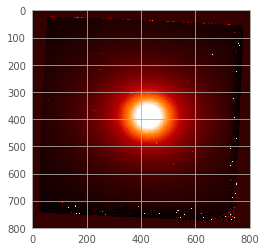

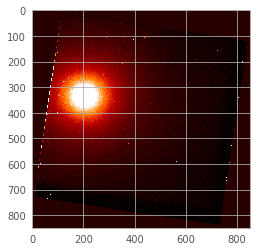

In [4]:
plt.imshow(wide_band, vmin=np.percentile(wide_band, 1), vmax=np.percentile(wide_band, 99))
plt.show()
plt.imshow(narrow_band, vmin=np.percentile(narrow_band, 1), vmax=np.percentile(narrow_band, 99))
plt.show()

Wide band center: 390 427
Narrow band center: 335 204


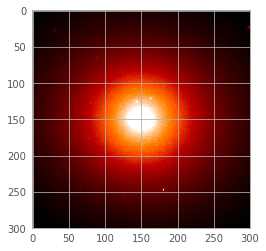

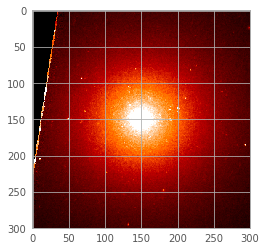

In [5]:
# crop the images around the galaxy
wcs_wide=wcs.WCS(wide_band_hdr)
wcs_narrow=wcs.WCS(narrow_band_hdr)

result_table = Ned.query_object('NGC 4649')

ra = result_table['RA'][0]
dec = result_table['DEC'][0]

center_w = wcs_wide.wcs_world2pix(ra, dec, 0)
center_n = wcs_narrow.wcs_world2pix(ra, dec, 0)

# Align the centers
xw = int(center_w[0])-36
yw = int(center_w[1])+37
xn = int(center_n[0])+132
yn = int(center_n[1])-132
delta = 150

print("Wide band center:",xw,yw)
print("Narrow band center:",xn,yn)

wide_band_crop = wide_band[xw-delta:xw+delta,yw-delta:yw+delta]
narrow_band_crop = narrow_band[xn-delta:xn+delta,yn-delta:yn+delta]

plt.imshow(wide_band_crop, vmin=np.percentile(wide_band_crop, 1), vmax=np.percentile(wide_band_crop, 99))
plt.savefig("C:/Users/emily/Documents/ARC Summer 2019/Images/"+galaxy+"_wide_band.png")
plt.show()
plt.imshow(narrow_band_crop, vmin=np.percentile(narrow_band_crop, 1), vmax=np.percentile(narrow_band_crop, 99))
plt.savefig("C:/Users/emily/Documents/ARC Summer 2019/Images/"+galaxy+"_narrow_band.png")
plt.show()

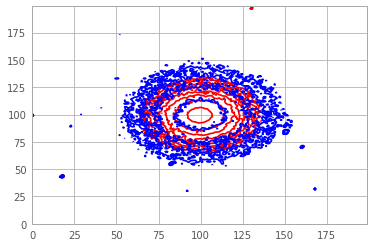

In [6]:
delta_2 = 100
plt.contour(wide_band[xw-delta_2:xw+delta_2,yw-delta_2:yw+delta_2], colors='red', levels=np.percentile(wide_band[np.where(wide_band !=0)],np.arange(99.2,99.9,0.1)))
plt.contour(narrow_band[xn-delta_2:xn+delta_2,yn-delta_2:yn+delta_2], colors='blue', levels=np.percentile(narrow_band[np.where(narrow_band!=0)],np.arange(98.8,99.95,0.35)))
plt.savefig("C:/Users/emily/Documents/ARC Summer 2019/Images/"+galaxy+"_contours")

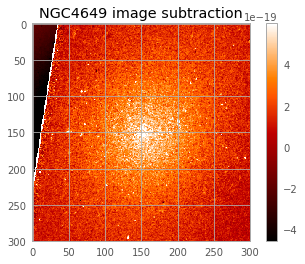

In [7]:
subtracted = narrow_band_crop-wide_band_crop
plt.imshow(subtracted, vmin=np.percentile(subtracted, 1), vmax=np.percentile(subtracted, 99))
plt.colorbar()
plt.title(galaxy+" image subtraction")
plt.savefig("C:/Users/emily/Documents/ARC Summer 2019/Images/"+galaxy+"_subtracted_crop.png")

In [8]:
# the version that works
r_inner = 75
r_outer = 100

y = np.arange(wide_band_crop.shape[0])
x = np.arange(wide_band_crop.shape[1])

xx, yy = np.meshgrid(x, y)

c1 = (xx-delta)**2 + (yy-delta)**2 > r_inner**2
c2 = (xx-delta)**2 + (yy-delta)**2 < r_outer**2
z = c1*c2

narrow_band_pixels = z*narrow_band_crop
wide_band_pixels = z*wide_band_crop
            
X = wide_band_pixels[np.nonzero(wide_band_pixels)].reshape(-1,1)
Y = narrow_band_pixels[np.nonzero(narrow_band_pixels)].reshape(-1,1)

1.0142381191253662 2.338389960850656e-19


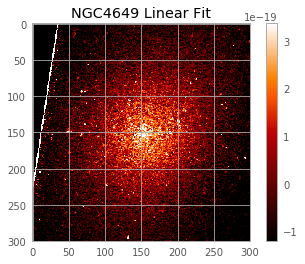

In [9]:
reg = RANSACRegressor(random_state=0).fit(X, Y)

a = float(reg.estimator_.coef_)
b = float(reg.estimator_.intercept_)
print(a,b)
subtracted = narrow_band_crop-a*wide_band_crop-b*np.ones(wide_band_crop.shape)
plt.imshow(subtracted, vmin=np.percentile(subtracted, 20), vmax=np.percentile(subtracted, 99))
plt.colorbar()
plt.title(galaxy+" Linear Fit")
plt.savefig("C:/Users/emily/Documents/ARC Summer 2019/Images/"+galaxy+"_RANSAC_subtracted.png")

inliers:  0.8504223711039907


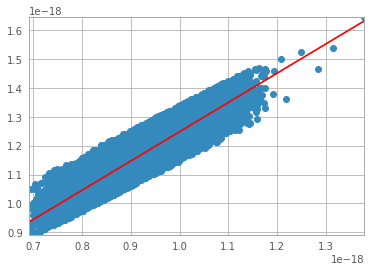

In [10]:
X_in = X[reg.inlier_mask_]
Y_in = Y[reg.inlier_mask_]
plt.scatter(X_in, Y_in)
plt.plot([0,1], [b, a+b], 'r')
plt.axis([X_in.min(), X_in.max(), Y_in.min(), Y_in.max()])
print("inliers: ", reg.inlier_mask_.sum()/reg.inlier_mask_.size)
#plt.savefig("C:/Users/emily/Documents/ARC Summer 2019/Images/"+galaxy+"_fit.png")
plt.show()

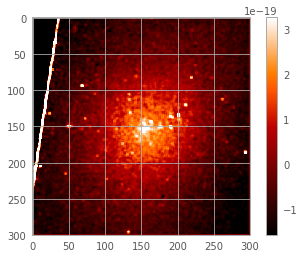

In [11]:
w_2 = 2
subtracted_2 = np.zeros(subtracted.shape)

for y in range(w_2, subtracted.shape[0]-w_2):
    for x in range(w_2, subtracted.shape[1]-w_2):
        avg = 0.0
        for i in range(-w_2, w_2):
            for j in range(-w_2, w_2):
                avg = avg + subtracted[x+i,y+j]/(w_2*2.0)**2.0
        subtracted_2[x,y] = avg

plt.imshow(subtracted_2, vmin=np.percentile(subtracted_2, 5), vmax=np.percentile(subtracted_2, 99))
plt.colorbar()

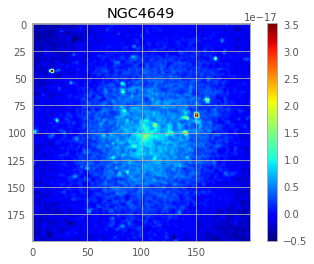

In [12]:
result_table = Ned.query_object('NGC 4649')

ra = result_table['RA'][0]
dec = result_table['DEC'][0]

full_image = subtracted*narrow_band_hdr['photbw']
hdr = narrow_band_hdr
hdr['CRPIX1'] = delta
hdr['CRPIX2'] = delta
hdr['CRVAL1'] = ra
hdr['CRVAL2'] = dec
hdr['ra_aper'] = ra
hdr['dec_aper'] = dec
hdr['bunit'] = 'erg/s/cm2'
hdr['goodmin'] = np.percentile(full_image, 10)
hdr['goodmax'] = np.percentile(full_image, 99.5)
hdr.set('target', 'NGC4649', 'target name')

hdu = fits.PrimaryHDU(data=full_image, header=hdr)
#hdu.writeto("C:/Users/emily/Documents/ARC Summer 2019/FITS files/Subtracted/"+galaxy+"_subtracted.fits")

plt.imshow(ndi.gaussian_filter(full_image[50:250,50:250], 1.0), vmin=np.percentile(full_image, 10), vmax=np.percentile(full_image, 99.5), cmap=mat.cm.jet)
plt.colorbar()
plt.title(galaxy)
plt.savefig(ims+"final/"+galaxy+"_Ha.jpg", bbox_inches = 'tight')

Flux correction:  -4.1642308524514474e-19


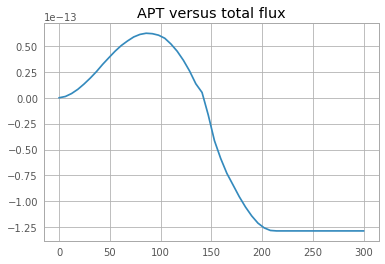

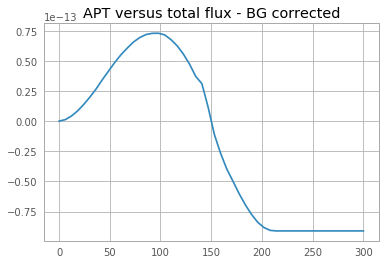

Galactic flux: 7.295535463824444e-14 pixel value: 97


In [13]:
# summing up the image for the total flux

fluxes = []
fluxes_corr = []

pix = np.linspace(0, full_image.shape[0], num=50)

for r in pix:
    z = (xx-delta)**2+(yy-delta)**2<r**2
    flux = (z*full_image).sum()
    fluxes.append(flux)

R = int(full_image.shape[0]/2)
z = (xx-delta)**2+(yy-delta)**2<R**2
f_bg = (z*full_image).sum()/np.pi/R**2
print("Flux correction: ", f_bg)

bg_corr = full_image - f_bg*np.ones(full_image.shape)

for r in pix:
    z = (xx-delta)**2+(yy-delta)**2<r**2
    flux_corr = (z*bg_corr).sum()
    fluxes_corr.append(flux_corr)
    
plt.plot(pix, fluxes)
plt.title("APT versus total flux")
plt.show()
plt.plot(pix, fluxes_corr)
plt.title("APT versus total flux - BG corrected")
plt.show()
f = max(fluxes_corr[0:20])
apt = int(pix[fluxes_corr.index(f)])
print("Galactic flux:", f, "pixel value:", apt)

MAD: 1.812125342145733e-18 , Error:  3.11555128477939e-16
Std:  1.95855709830104e-18 , Error:  3.3673085089689516e-16
% of image:  0.08626666666666667


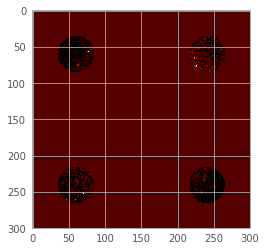

In [14]:
# calculate standard deviation
f = max(fluxes)
w = 25
offset = 90

z1 = (xx-delta-offset)**2+(yy-delta-offset)**2 < w**2
z2 = (xx-delta+offset)**2+(yy-delta-offset)**2 < w**2
z3 = (xx-delta+offset)**2+(yy-delta+offset)**2 < w**2
z4 = (xx-delta-offset)**2+(yy-delta+offset)**2 < w**2
z = z1+z2+z3+z4

noise_pixels = (z*full_image).flatten()
noise_pixels = noise_pixels[np.where(noise_pixels!=0)]

apt_size = np.pi*(apt**2)

k = 1.4826
mad = k*MAD(noise_pixels)
std = np.std(noise_pixels)
plt.imshow(z*full_image, vmin=np.percentile(full_image, 30), vmax=np.percentile(full_image, 99))
print("MAD:", mad, ", Error: ", mad*np.sqrt(apt_size))
print("Std: ", std, ", Error: ", std*np.sqrt(apt_size))
print("% of image: ", z.sum()/full_image.shape[0]**2)

In [15]:
a_err = mad / (X_in.std()*np.sqrt(len(X_in)+1))
b_err = mad * np.sqrt((X_in**2).mean())/(X_in.std()*np.sqrt(len(X_in)+1))

print("Slope error: ", a_err, ", Intercept error: ", b_err)

z = (xx-delta)**2+(yy-delta)**2<apt**2
wide_ap = (z*wide_band_crop).sum()
sys_err = np.sqrt((a_err* wide_ap)**2 + (z.sum()*b_err)**2)

print("Systematic error: ", sys_err, ",", sys_err/f*100, "%")

Slope error:  0.16618325065264403 , Intercept error:  1.5397398515539184e-19
Systematic error:  7.804560163199719e-15 , 12.532910922388693 %


[98.5, 98.87375, 99.2475, 99.62125, 99.995]


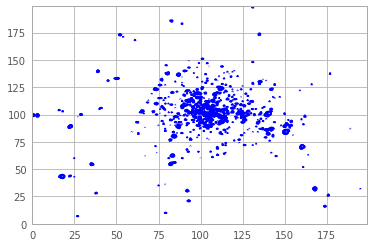

In [16]:
# contour subtracted flux
nums = np.linspace(98.5, 99.995, num=5)
nums = list(nums)
#nums.insert(0, 99.5)
#nums.insert(0, 99)
print(nums)
plt.contour(full_image[50:250,50:250], colors='blue', levels=np.percentile(full_image,nums))

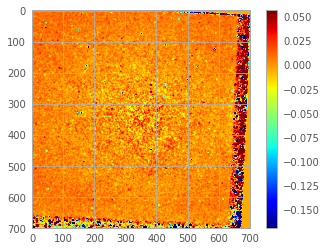

In [17]:
%matplotlib inline
dust_file = "C:/Users/emily/Documents/ARC Summer 2019/FITS files/Dust/NGC4649_dust_colorsub_smoothed.fits"
with fits.open(dust_file) as df:
    dust_hdr = df[1].header
    dust = df[1].data
    
dust_img = -ndi.gaussian_filter(dust, 1.0)
dustmin = np.percentile(dust_img, 1)
dustmax = np.percentile(dust_img, 98)
    
plt.imshow(dust_img, vmin=dustmin, vmax=dustmax, cmap=mat.cm.jet)
plt.colorbar()

1
[150]
['0']
3
[150 350 550]
['-10', '0', '10']
3
[150 350 550]
['-10', '0', '10']


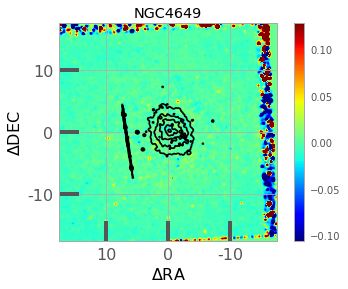

In [18]:
%matplotlib qt
plt.clf()
nums = [1e-18, 3e-18, 5e-18, 7e-18, 1e-17, 2e-17]
import make_astro_map as mam
ax1,extw1,w1=mam.make_plot(full_image,hdr,dval=10.01,cmap=mat.cm.jet,vmin=-1e-17,vmax=7e-17)
ax2,extw2,w2=mam.make_plot(dust,dust_hdr,dval=10.01,cmap=mat.cm.jet,vmin=-0.1,vmax=0.3)

import scipy.ndimage as ndi
mam.make_plot(ndi.gaussian_filter(dust,3.0),dust_hdr,dval=10.01,cmap=mat.cm.jet,vmin=np.percentile(dust, 1), vmax=np.percentile(dust, 99))
#mam.make_plot(ndi.gaussian_filter(full_image,3.0),hdr,dval=10.01,cmap=mat.cm.jet,vmin=np.percentile(full_image, 1), vmax=np.percentile(full_image, 99.5))
plt.colorbar()
plt.contour(ndi.gaussian_filter(full_image,3.0),extent=extw1,levels=nums,colors='k')
plt.title(galaxy)
plt.show()
plt.savefig(ims+galaxy+"_Ha_on_dust_contour.jpg")

In [19]:
#plt.savefig(ims+"final/"+galaxy+"_Ha_on_dust_contour.jpg", bbox_inches='tight')

In [20]:
# Contour the dust images
%matplotlib qt
plt.clf()
nums = np.array([-5, -3, -2, -1, 0])
import make_astro_map as mam
ax1,extw1,w1=mam.make_plot(full_image,hdr,dval=10.01,cmap=mat.cm.jet,vmin=-1e-17,vmax=7e-17)
ax2,extw2,w2=mam.make_plot(dust,dust_hdr,dval=10.01,cmap=mat.cm.jet,vmin=-0.1,vmax=0.3)

import scipy.ndimage as ndi
mam.make_plot(ndi.gaussian_filter(dust,2.0),dust_hdr,dval=10.01,cmap=mat.cm.jet,vmin=np.percentile(dust, 1), vmax=np.percentile(dust, 99))
#mam.make_plot(ndi.gaussian_filter(full_image,3.0),hdr,dval=10.01,cmap=mat.cm.jet,vmin=np.percentile(full_image, 1), vmax=np.percentile(full_image, 99))
plt.colorbar()
plt.contour(ndi.gaussian_filter(-dust,2.0),extent=extw2,levels=nums,colors='k')
plt.title(galaxy)
plt.show()

1
[150]
['0']
3
[150 350 550]
['-10', '0', '10']
3
[150 350 550]
['-10', '0', '10']
